In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6


In [2]:
data = pd.read_csv('listings_tot.csv')

/home/biel/anaconda2/envs/geoviews/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [19]:
num_hogares = pd.read_csv("../datasets/num_hogares/NumHogaresYFamilias2011.csv", sep=";")

In [20]:
num_hogares.head()

Distrito                                   Barrio   NumHogares  \
0         1                               1.el Raval       17.752   
1         1                         2.el Barri Gòtic        8.209   
2         1                         3.la Barceloneta        8.164   
3         1  4.Sant Pere, Santa Caterina i la Ribera       10.380   
4         2                          5.el Fort Pienc       13.166   

    NumFamilias   NumNucleos       .1   .2  
0        10.763       11.251 NaN  NaN  NaN  
1         4.313        4.295 NaN  NaN  NaN  
2         4.932        4.900 NaN  NaN  NaN  
3         5.744        5.628 NaN  NaN  NaN  
4         9.109        8.966 NaN  NaN  NaN

In [21]:
# strip space in the begining of column name
num_hogares.columns = num_hogares.columns.str.lstrip()

In [22]:
# ugly number cleaning
def drop_digits(in_str):
    digit_list = "1234567890"
    for char in digit_list:
        in_str = in_str.str.replace(char, "")

    return in_str

In [23]:
num_hogares.Barrio = drop_digits(num_hogares.Barrio)
num_hogares.Barrio = num_hogares.Barrio.str.replace(".", "")

n_airbnbs_barri= data.neighbourhood_cleansed.value_counts()

n_airbnbs_barri = n_airbnbs_barri[n_airbnbs_barri.index.isin(num_hogares.Barrio)]

num_hogares = num_hogares[num_hogares.Barrio.isin(n_airbnbs_barri.index)]

num_hogares.index = num_hogares.Barrio

num_hogares.drop("Barrio", axis=1)[:2]

Distrito  NumHogares  NumFamilias  NumNucleos      .1  .2
Barrio                                                                   
el Raval               1      17.752       10.763      11.251 NaN NaN NaN
el Barri Gòtic         1       8.209        4.313       4.295 NaN NaN NaN

In [24]:
num_hogares = num_hogares.NumHogares

#num_hogares.drop(["Can Peguera", "Baró de Viver", "Torre Baró", "Vallbona"], inplace=True)#outliers

num_hogares=num_hogares * 1000 #ugly hack to get rid of the "." decimal

density = n_airbnbs_barri/num_hogares

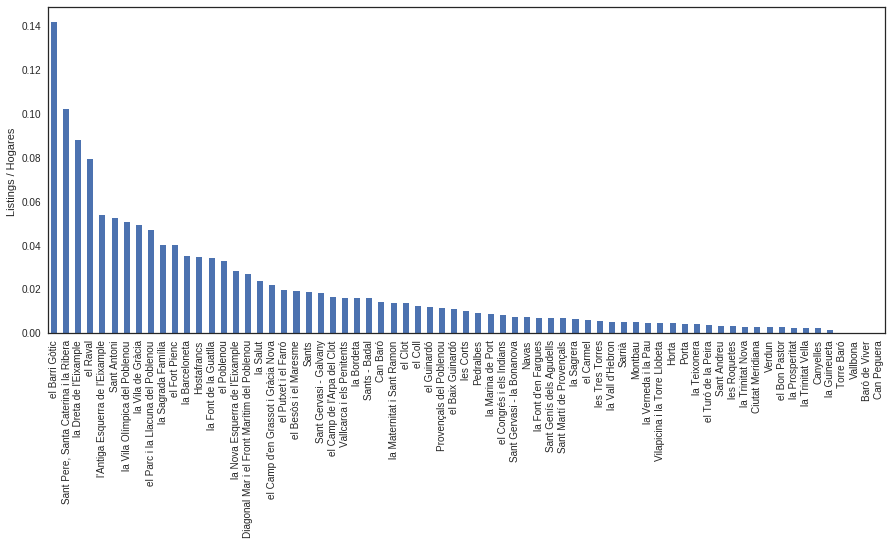

In [26]:
density.sort_values(ascending=False).plot(kind ="bar",)
plt.ylabel("Listings / Hogares ")

plt.savefig("density.png", format="png")

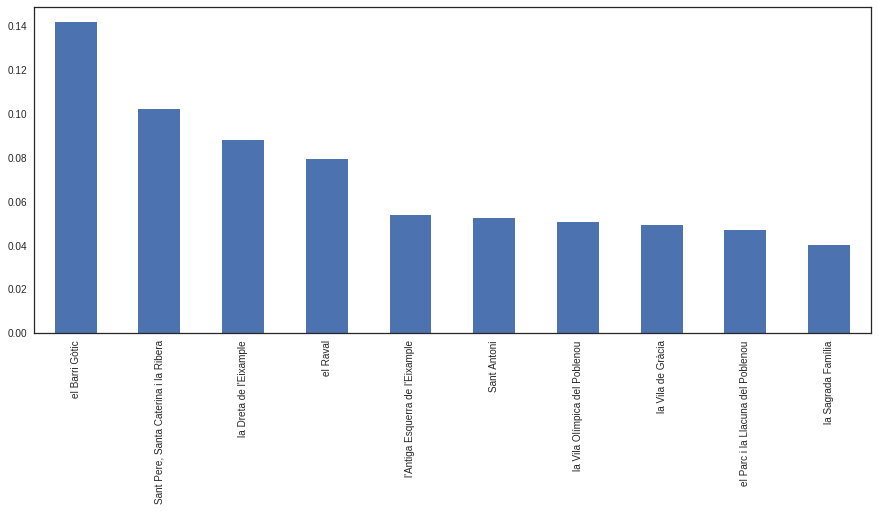

In [27]:
density.sort_values(ascending=False).head(10).plot(kind="bar")
plt.savefig("density10.png")

# Choropleth with Holoviews and Bokeh of the density

In [28]:
barri_json_path = r"../datasets/divisiones_administrativas/barris/barris_geo.json"

In [29]:
from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

## test geojson

In [30]:

from bokeh.models import (
    GeoJSONDataSource,
    HoverTool,
    LinearColorMapper
)
from bokeh.plotting import figure
from bokeh.palettes import Viridis6

with open(barri_json_path, 'r') as f:
    geo_source = GeoJSONDataSource(geojson=f.read())


color_mapper = LinearColorMapper(palette=Viridis6)

TOOLS = "pan,wheel_zoom,box_zoom,reset,hover,save"

p = figure(title="barris", tools=TOOLS, x_axis_location=None, y_axis_location=None, width=800, height=800)
p.grid.grid_line_color = None

p.patches('xs', 'ys', fill_alpha=0.7, 
          line_color='white', line_width=0.5, source=geo_source)


hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [("Provincia:", "$properties""$N_Barri")]

#output_file("PBIar.html", title="Testing islands in bokeh")

show(p)

In [31]:
import xarray as xr
import numpy as np
import pandas as pd
import holoviews as hv
import geoviews as gv
import geoviews.feature as gf

import cartopy
from cartopy import crs as ccrs

from bokeh.tile_providers import STAMEN_TONER
from bokeh.models import WMTSTileSource

hv.notebook_extension('bokeh')

/home/biel/anaconda2/envs/geoviews/lib/python2.7/site-packages/xarray/core/formatting.py:16: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime
/home/biel/anaconda2/envs/geoviews/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The Vega20 colormap was deprecated in version 2.0. Use tab20 instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/biel/anaconda2/envs/geoviews/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The Vega20b colormap was deprecated in version 2.0. Use tab20b instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/biel/anaconda2/envs/geoviews/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The Vega20c colormap was deprecated in version 2.0. Use tab20c instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/biel/anaconda2/envs/geoview

In [32]:
density = pd.DataFrame({"N_Barri":density.index, "value":density.values})

In [34]:
shapefile = "../datasets/divisiones_administrativas/barris/shape/barris_geo.shp"
shapes = cartopy.io.shapereader.Reader(shapefile)
density_hv = hv.Dataset(density)

In [35]:
density_hv.data.dropna(inplace=True)

In [46]:

%%opts Shape (cmap='Blues') [tools=['hover'] width=800 height=800 colorbar=True toolbar='above' xaxis=None yaxis=None]
%%output filename="holoviews"
gv.Shape.from_records(shapes.records(), density_hv, on='N_Barri', value='value',
                      index='N_Barri', crs=ccrs.PlateCarree(), group="Densitat Airbnb Barcelona per nombre d'hogars",
                      drop_missing=False).redim(name='County', leaveVoteshare='Leave Vote %')


:NdOverlay   [N_Barri]
   :Shape   [Longitude,Latitude]   (value)